In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [0]:
import pandas as pd
#from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import json
#%matplotlib inline


#uploaded = files.upload()
#import io 
#df= pd.read_csv(io.BytesIO(uploaded['Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv']))
#df= pd.read_csv('ZeroBias_2017UL_DataFrame_ChargeInnerLayer4.txt')
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv')
df['histo']=df['histo'].apply(literal_eval)

df.set_index(['fromrun','fromlumi'], inplace=True, drop=False)
df.sort_index(inplace=True)
print(df['histo'].shape)
print(df.tail())
print(df.shape)

In [0]:
import seaborn as sns
from pylab import rcParams
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
import tensorflow
#from tensorflow import set_random_seed
tensorflow.random.set_seed(2)
#set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 10, 8




In [0]:
#add Golden JSON labels to the DF
import json

def checkLS(run,ls):
    isok=False
    global jsondata
    
    if str(run) in jsondata.keys():
        for i in jsondata[str(run)]:
            if (ls>=i[0] and ls <=i[1]):
                isok=True
                return isok
        return isok

#load the golden json file
jsondata={}
with open('/content/drive/My Drive/Colab Notebooks/GoldenJSON17.json') as json_file:
    jsondata = json.load(json_file)

df['labels']=False #initialize to false

for run in df['fromrun'].unique():
    for ls in df['fromlumi'][run]:
        df['labels'][run][ls]=checkLS(run,ls)

#fname_bad = 'BAD_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.txt'
#fname_gold = 'GOLDEN_Tot_ZeroBias_UL2017_DataFrame_chargeInner_PXLayer_1.csv'
#df[df['labels']!=True].to_csv(fname_bad)
#df[df['labels']==True].to_csv(fname_gold)

print(df[df['labels']!=True]) #to check against the Golden JSON
print(df.shape)
print(df['labels'])


In [0]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train_true = np.stack(df_train['histo'][df_train['labels']==True].values, axis=0)
X_train_false = np.stack(df_train['histo'][df_train['labels']==False].values, axis=0)

X_valid_true = np.stack(df_valid['histo'][df_valid['labels']==True].values, axis=0)
X_valid_false = np.stack(df_valid['histo'][df_valid['labels']==False].values, axis=0)


X_test_true = np.stack(df_test['histo'][df_test['labels']==True].values, axis=0)
X_test_false = np.stack(df_test['histo'][df_test['labels']==False].values, axis=0)

from sklearn.preprocessing import normalize

X_train_true_norm=normalize(X_train_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_train_false_norm=normalize(X_train_false, norm='l1', axis=1)

X_valid_true_norm=normalize(X_valid_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_valid_false_norm=normalize(X_valid_false, norm='l1', axis=1)

X_test_true_norm=normalize(X_test_true, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test_false_norm=normalize(X_test_false, norm='l1', axis=1)

#print(df['labels'])


In [0]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean

nb_epoch = 100
batch_size = 500
input_dim = X_train_true_norm.shape[1] #num of predictor variables, 
encoding_dim = 10
#hidden_dim = int(encoding_dim / 2)
hidden_dim = 3
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
#encoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(hidden_dim, activation="tanh")(encoder)
decoder = Dense(encoding_dim, activation="tanh")(decoder)
decoder = Dense(input_dim, activation="tanh")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

In [0]:
autoencoder.compile(metrics=['accuracy'],
                    loss=mseTop10,
                    optimizer='adam')
cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_true_norm, X_train_true_norm,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_valid_true_norm, X_valid_true_norm),
                    verbose=1,
                    callbacks=[cp, tb]).history

In [0]:
print(history)

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

# "Loss"
plt.figure(1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale("log")
#plt.xlim(0,100)
plt.show()

#plot_loss(history, "Original model loss")

In [0]:
print(df['labels'])

In [0]:
# Let’s plot the Transaction class against the Frequency
#labels = [‘True’,’False’]
classes = pd.value_counts(df['labels'], sort = True)
classes.plot(kind = ‘bar’, rot=0)
plt.title(“Transaction class distribution”)
plt.xticks(range(2), labels)
plt.xlabel(“labels”)
plt.ylabel(“Frequency”)

In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
error_df = pd.DataFrame({'Reconstruction_error': mse_valid,
                        'True_class': df_valid['labels']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()



In [0]:
X_test_all = np.stack(df_test['histo'].values, axis=0)
X_test_all_norm=normalize(X_test_all, norm='l1', axis=1)

test_x_predictions = autoencoder.predict(X_test_all_norm)
#mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
mse_test=K.eval(mseTop10(X_test_all_norm, test_x_predictions))
error_df_test = pd.DataFrame({'Reconstruction_error': mse_test,
                        'True_class': df_test['labels']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.0009
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == False else "Good")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="black", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
LABELS = ["Good","Anomaly"]
pred_y = [False if e > threshold_fixed else True 
          for e in error_df_test.Reconstruction_error.values]
          
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df_test.True_class, error_df_test.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print(X_train_true_norm.shape)
print(X_valid_true_norm.shape)
print(X_test_true_norm.shape)

In [0]:
#LSTM
from numpy import array
from keras.models import Sequential
from keras.models import Sequential
from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers.advanced_activations import ReLU

lr = 0.0001
# reshape input into [samples, timesteps, features]
timesteps = len(X_train_true_norm[0])
n_samples = X_train_true_norm.shape[0]
n_features = 1
X_train_lstm = X_train_true_norm.reshape((n_samples, timesteps, 1))
print(X_train_lstm.shape)

timesteps_valid = len(X_valid_true_norm[0])
n_samples_valid = X_valid_true_norm.shape[0]
n_features = 1
X_valid_lstm = X_valid_true_norm.reshape((n_samples_valid, timesteps_valid, 1))

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(10, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(5, activation='tanh', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(5, activation='tanh', return_sequences=True))
lstm_autoencoder.add(LSTM(10, activation='tanh', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()



In [0]:
epochs=100
batch=500

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='/content/drive/My Drive/Colab Notebooks/lstm_logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_lstm, X_train_lstm, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_lstm, X_valid_lstm),
                                                verbose=2).history

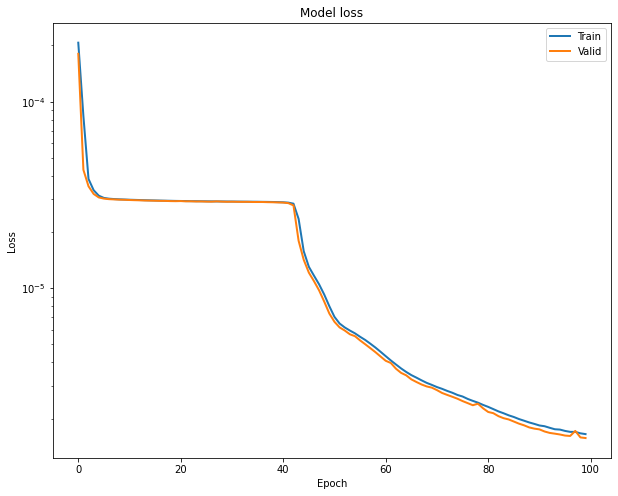

In [25]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale("log")
plt.show()

In [0]:
X_valid_all = np.stack(df_valid['histo'].values, axis=0)
X_valid_all_norm=normalize(X_valid_all, norm='l1', axis=1)

valid_x_predictions = autoencoder.predict(X_valid_all_norm)
#mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
mse_valid=K.eval(mseTop10(X_valid_all_norm, valid_x_predictions))
error_df = pd.DataFrame({'Reconstruction_error': mse_valid,
                        'True_class': df_valid['labels']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [0]:
0#extract test and train data and put in dataframes

#df_train=df.loc[df['labels']==True]
#df_test=df.loc[df['labels']==False]
X_trainCol = np.stack(df['histo'][df['labels']==True].values, axis=1) #convert list of array to a stack to feed the model
X_testCol = np.stack(df['histo'][df['labels']==False].values, axis=1)
X_trainS = np.stack(df['histo'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_testS = np.stack(df['histo'][df['labels']==False].values, axis=0)

print(X_trainCol.shape , X_trainS.shape)
print(X_trainCol)
print(X_trainS)

from sklearn.preprocessing import normalize

X_train=normalize(X_trainS, norm='l1', axis=1) #normalise the sample, i.e the rows
X_test=normalize(X_testS, norm='l1', axis=1)
print(X_train)
                      
df['origin']=''
df['origin'].loc[df['labels']==True]=X_train.tolist()
df['origin'].loc[df['labels']==False]=X_test.tolist()
print(df.shape)
print(df.origin.shape)

In [0]:
array_good=np.array(X_trainCol)
array_bad = np.array(X_testCol)

mean_good=np.mean(array_good, axis=1)
mean_bad=np.mean(array_bad, axis=1)

std_good=np.std(array_good, axis=1)
std_bad = np.std(array_bad, axis=1)

print(mean_good.shape)
print(std_good.shape)
print(mean_good)
print(std_good)


#bin =[]

#for i in range(1,101):
#    bin.append(i)

#print(bin)    
#np.reshape(bin, (100,1))
#print(bin.shape)
bin=np.arange(1,101)
bin.shape

#np.reshape(bin, (100,1))
#plt.plot(bin,mean_good)
plt.figure(1)
plt.errorbar(bin, mean_good, yerr=std_good, ecolor = 'green', label='both limits (default)')
plt.figure(2)
plt.errorbar(bin, mean_bad, yerr=std_bad, ecolor = 'red', label='both limits (default)')
plt.figure(3)
plt.errorbar(bin, mean_good, yerr=std_good, ecolor = 'green', label='both limits (default)')
plt.errorbar(bin, mean_bad, yerr=std_bad, ecolor = 'red', label='both limits (default)')
plt.show()
plt.figure(4)
plt.plot(bin, mean_good, color = 'green')
plt.plot(bin, mean_bad, color = 'red')
plt.figure(5)
plt.plot(bin, std_good, color = 'green')
plt.plot(bin, std_bad, color = 'red')
plt.show()


In [0]:
#build the model
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.models import load_model

def mseTop10(y_true, y_pred):
    top_values, _ = tf.nn.top_k(K.square(y_pred - y_true), k=10, sorted=True)
    mean=K.mean(top_values, axis=-1)
    return mean


input_size=len(X_train[0])
print(input_size)
input_layer = Input(shape=(input_size, ))
encoded = Dense(10, activation='tanh')(input_layer)
encoded1 = Dense(3, activation='tanh')(encoded)
encoded2 = Dense(10, activation='tanh')(encoded1)
decoder = Dense(input_size, activation='tanh')(encoded2)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder.layers):
             layer.name = 'layer_' + str(i)

autoencoder.summary()

In [0]:
history = autoencoder.fit(X_train,X_train, epochs=100, batch_size=500, shuffle=False, verbose=1,validation_split=0.1)

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history['loss'], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history['val_loss'], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    #plt.ylim(8258339,8258400)
    plt.yscale("log")
    plt.xlim(0,100)
    plt.show();

plot_loss(history, "Original model loss")

In [0]:
#LSTM
from numpy import array
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.layers.advanced_activations import ReLU

# define input sequence
X_train_lstm=normalize(X_trainS, norm='l1', axis=1)
X_test_lstm=normalize(X_testS, norm='l1', axis=1)
                      
df['lstm']=''
df['lstm'].loc[df['labels']==True]=X_train_lstm.tolist()
df['lstm'].loc[df['labels']==False]=X_test_lstm.tolist()

#sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#print(sequence.shape)
#n_in_seq = len(sequence)
#print(n_in_seq)
#sequence = sequence.reshape((1, n_in_seq, 1))
#print(sequence.shape)

# reshape input into [samples, timesteps, features]
n_in = len(X_train_lstm[0])
print(n_in)
print(X_train_lstm.shape)
X_train_lstm = X_train_lstm.reshape((202299, n_in, 1))
print(X_train_lstm.shape)
# define model
n_in = len(X_train_lstm[0])
model = Sequential()
model.add(LSTM(10, activation='tanh', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(10, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
for i, layer in enumerate(model.layers):
             layer.name = 'layer_' + str(i)

model.summary()
#history_lstm = model.fit(X_train_lstm,X_train_lstm, epochs=60, batch_size=500, shuffle=False, verbose=1,validation_split=0.1)
# fit model
#model.fit(sequence, sequence, epochs=300, verbose=0)
#plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [0]:
#print(history)

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data.history['loss'], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data.history['val_loss'], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    #plt.ylim(8258339,8258400)
    plt.yscale("log")
    plt.xlim(0,60)
    plt.show();

plot_loss(history_lstm, "Original model loss for LSTM")

In [0]:
predictionTest=autoencoder.predict(X_test)
predictionTrain=autoencoder.predict(X_train)

mseTest=K.eval(mseTop10(X_test, predictionTest))
mseTrain=K.eval(mseTop10(X_train, predictionTrain))

df['prediction']=""
df['mse']=""

df['prediction'].loc[df['labels']==True]=predictionTrain.tolist()
df['prediction'].loc[df['labels']==False]=predictionTest.tolist()

df['mse'].loc[df['labels']==True]=mseTrain
df['mse'].loc[df['labels']==False]=mseTest

print(df.head())
#print(df_test.head())


In [0]:
def globalMSETrend(df,type=1):
    
    y=[]
    
    rmax=0
    rmin=10
    
    print(rmax, rmin)
    for run in df['fromrun'].unique():
        if (type==1): val=(df['mse'][run]).mean()
        if (type==2): val=(df['mse2'][run]).mean()
        if val > rmax: rmax=val
        if val < rmin: rmin =val
        y.append(val)
    
    array=np.array(y)
    gmean=array.mean()
    size=float(array.size)
    gstd=array.std()
    print(size)
    
    fig=plt.figure()
    fig.set_size_inches(16, 9)
    
    plt.hlines(gmean,df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="blue", label="Run average: " + str(gmean))
    plt.hlines(gmean+(1.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='1 SD (' + str(gstd) + ")")
    plt.hlines(gmean+(3.0*gstd), df['fromrun'].unique().min(), df['fromrun'].unique().max(), color="red", label='3 SD', linestyle=':')
    
    plt.ylim(rmin*0.9,rmax*1.1)
    plt.scatter(df['fromrun'].unique(), y, marker='+', label='Data points')
    plt.xlabel("Run")
    plt.ylabel("average MSE")
    plt.legend()
    plt.show()

In [0]:
globalMSETrend(df[df.labels==True])

In [0]:
def CheckPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    mse=df_test['mse'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Reco MSE=" + str(mse))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

In [0]:
for run in df['fromrun'].unique():
    count=0
    for ls in df['fromlumi'][run]: 
        if df['labels'][run][ls]== False: continue
        if (count >2): continue
        count=count+1
        #CheckPredictions(df[df.train==True], run,ls)
        CheckPredictions(df[df['labels']==True], run,ls)

In [0]:
import pandas as pd
import numpy as np
#X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0) #convert list of array to a stack to feed the model
X_trainA = np.stack(df['origin'][df['labels']==True].values, axis=0)
#no need to normalize, we already have the normalized histogram in the df
print(X_trainA)

In [0]:
input_size=len(X_train[0])
input_layerA = Input(shape=(input_size, ))

encodedA = Dense(20, activation='sigmoid')(input_layerA)
encoded1A = Dense(10, activation='tanh')(encodedA)
encoded2A = Dense(20, activation='sigmoid')(encoded1A)
decoderA = Dense(input_size, activation='sigmoid')(encoded2A)

autoencoder_Opt = Model(inputs=input_layerA, outputs=decoderA)
autoencoder_Opt.compile(optimizer='adam', loss=mseTop10)

for i, layer in enumerate(autoencoder_Opt.layers):
             layer.name = 'layer_' + str(i)

autoencoder_Opt.summary()

In [0]:
history_Opt = autoencoder_Opt.fit(X_trainA,X_trainA, epochs=300, batch_size=100, shuffle=True, verbose=1,validation_split=0.1)

In [0]:
#calculate predictions and mse and add to original DF

originS=np.stack(df['origin'].values, axis=0)
predictionA=autoencoder_Opt.predict(originS)

mseA=K.eval(mseTop10(originS,predictionA))

df['predictions2']=""
df['mse2']=""

df['prediction2']=predictionA.tolist()
df['mse2']=mseA


print(df.head())

In [0]:
def CheckAllPredictions(df_test, run, ls):

    Xmax=80000.0
    Xmin=0.0
    Xbins=100
    hname="chargeInner_PXLayer_1"
    
    ahisto=df_test['origin'][run][ls]
    ahisto1=df_test['prediction'][run][ls]
    ahisto2=df_test['prediction2'][run][ls]
    mse=df_test['mse'][run][ls]
    mse2=df_test['mse2'][run][ls]
    
    x= np.linspace(Xmin,Xmax,Xbins)
    #plt.xlim(Xmin,Xmax)
    
    plt.step(x, ahisto, where='mid', label=(" Data " + str(df_test.fromlumi[run][ls]) + " Run " + str(df_test.fromrun[run][ls]) ))
    plt.step(x, ahisto1, where='mid', label=" Raw Reco, mse:" + str(mse))
    plt.step(x, ahisto2, where='mid', label=" Reco, mse:" + str(mse2))
    plt.xlabel("Charge electrons")
    plt.ylabel("A.U")
    plt.legend()
    plt.show()

In [0]:
#compare some old and new predictions

for run in df['fromrun'].unique():
    count=0
    if run <298000: continue
    for ls in df['fromlumi'][run]: 
        if df['train'][run][ls]== True: continue
        if df['mse2'][run][ls]<0.00001: continue
        if df['entries'][run][ls]<3000: continue
        #if (count >2): continue
        count=count+1
        #print(df.entries)[run][ls]
        CheckAllPredictions(df[df.train==False], run,ls)